**Name:** Ghazal Farahani

**Student ID:** 98104358

In this practical assignment, we will develope a U-Net for semantis segmentation of lung CT-scans.

For this task, you will use a dataset consisting of CT-scans from lungs of COVID-19 patients. The regions affected by COVID-19 are marked with labels of ground glass opacity. You will be training and testing the U-Net model on this dataset.

## Imports

In [1]:
# Import any needed packages here
import torch
import numpy as np
from matplotlib import pyplot as plt
from torch import nn
import tensorflow as tf
import cv2

## Prepare Data
Now download and unzip the data. (Note: If you face any problems for downloading uzing gdown and unzipping, you may also download the data manually using the Goggle Drive links in the code)

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
images = np.load('/content/gdrive/MyDrive/lung_CT_scans/images_medseg.npy').astype(np.float32)
masks = np.load('/content/gdrive/MyDrive/lung_CT_scans/masks_medseg.npy').astype(np.float32)

In [52]:
print("Images Shape:", images.shape)
print("Masks Shape:", masks.shape)

Images Shape: (100, 512, 512, 1)
Masks Shape: (100, 512, 512, 4)


The dataset consists of 100 CT images with size 512*512. In the Masks data,for each image 4 masks are provided with different meanings. The first mask (index 0) is the ground glass opacity class, indicating the regions affected by COVID-19. Also, the last mask (index 4) is the background class.

You can see the visulaiztion of a few of the CT images, and their given masks using the code below. In this assignment, use the first mask (ground glass opacity) for the segmentation task (You may also test it on other classes if you like too!)

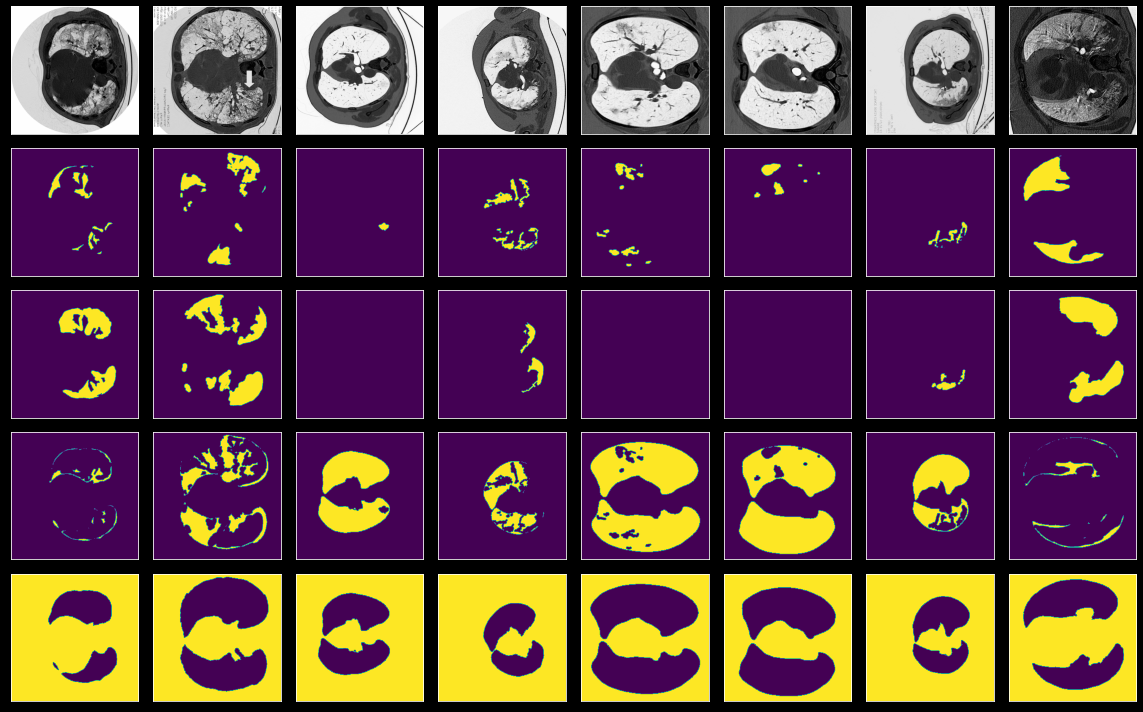

In [4]:
import matplotlib.pyplot as plt

plt.style.use("dark_background")

def visualize(image_batch, mask_batch=None, pred_batch=None, num_samples=8):
    num_classes = mask_batch.shape[-1] if mask_batch is not None else 0
    fix, ax = plt.subplots(num_classes + 1, num_samples, figsize=(num_samples * 2, (num_classes + 1) * 2))
    for i in range(num_samples):
        ax_image = ax[0, i] if num_classes > 0 else ax[i]
        ax_image.imshow(image_batch[i,:,:,0], cmap="Greys")
        ax_image.set_xticks([]) 
        ax_image.set_yticks([])
        
        if mask_batch is not None:
            for j in range(num_classes):
                if pred_batch is None:
                    #print(j)
                    mask_to_show = mask_batch[i,:,:,j]
                else:
                    mask_to_show = np.zeros(shape=(*mask_batch.shape[1:-1], 3)) 
                    mask_to_show[..., 0] = pred_batch[i,:,:,j] > 0.5
                    mask_to_show[..., 1] = mask_batch[i,:,:,j]
                ax[j + 1, i].imshow(mask_to_show, vmin=0, vmax=1)
                ax[j + 1, i].set_xticks([]) 
                ax[j + 1, i].set_yticks([]) 

    plt.tight_layout()
    plt.show()


visualize(images, masks)

## Create Your Dataset Class (10%)

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset


class Dataset(torch.utils.data.Dataset):

  def __init__(self, images, masks, transform=None, target_transform=None):
        self.images = images
        self.masks = masks
        self.transform = transform

  def __len__(self):
      return len(self.images)

  def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img = self.images[idx]
        label = self.masks[idx]
        return (torch.from_numpy(np.array(Image.fromarray(img * 255).convert('RGB')).transpose((2, 0, 1))).float(),
                torch.from_numpy(label[np.newaxis,...]).float())

def normalize(img):
   img = img - np.min(img)
   img = img / (np.max(img) - np.min(img))
   return img

def resize(img, output_size):
  return cv2.resize(img, output_size)

def preprocess(img, output_size):
  img = normalize(img)
  img = resize(img, output_size)
  return img

masks = np.array([masks[i][:, :, 3] for i in range(100)])
images = images[:, :, :, 0]
new_images, new_masks = [], []
[new_images.append(preprocess(img, (224, 224))) for img in images]
[new_masks.append(resize(mask, (224, 224))) for mask in masks]

dataset = Dataset(np.array(new_images), np.array(new_masks))

## Split Dataset and Dataloader (5%)

In this part, split the dataset (80% train, 10% validation, 10% test). Then, create your train and validation DataLoader, using random shuffle and batch size of 4.

In [5]:
from torch.utils.data import random_split
from torch.utils.data import DataLoader

n = len(dataset)
batch_size = 4

train_data, valid_data, test_data = random_split(dataset, [int(0.8 * n), int(0.1 * n), int(0.1 * n)])

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=True)

## Implement your U-Net (45%)

In this section implement your U-Net model, inherited from torch.nn.Module.

In the next text cell, explain the architecture of the implemented U-Net. Then, complete the code cell to creat your class.

##U-Net: 
* This architecture proposed for semantic segmentation, first for medical images. how it works is based on extract features first from image. this is the downsampling part. for upsampling part(beacause we need our output to have same size as the input), we use features in downsapling part to create mask.


###Contracting Block:
* This block is a set of convolutions with pooling which downsizes the image  extract features from the original image by applying conv layers on it.

### bottleneck: 
* In this implementation we don't have any middle block for simplicity but this layer is a set of convolutions to increase the number of features.

### Expanding Block:
* The key-point in the expanding blocks is usage of transpose convolution to upsample.

At the end by adding these blocks we can build out U-Net model for segmentation.

In [6]:
class UNET(nn.Module):
    def __init__(self, in_channels, out_channels):

        super().__init__()

        self.conv1 = self.contract_block(in_channels, 32, 7, 3)
        self.conv2 = self.contract_block(32, 64, 3, 1)
        self.conv3 = self.contract_block(64, 128, 3, 1)
        self.conv4 = self.contract_block(128, 256, 3, 1)

        self.upconv4 = self.expand_block(256, 128, 3, 1)
        self.upconv3 = self.expand_block(256, 64, 3, 1)
        self.upconv2 = self.expand_block(128, 32, 3, 1)
        self.upconv1 = self.expand_block(64, 16, 3, 1)

        self.outputs = nn.Conv2d(16,out_channels, kernel_size=3, padding=1)

    def __call__(self, x):

        # downsampling part
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)

        upconv4 = self.upconv4(conv4)
        upconv3 = self.upconv3(torch.cat([upconv4, conv3], 1))
        upconv2 = self.upconv2(torch.cat([upconv3, conv2], 1))
        upconv1 = self.upconv1(torch.cat([upconv2, conv1], 1))

        outputs = self.outputs(upconv1)

        return torch.sigmoid(outputs)

    def contract_block(self, in_channels, out_channels, kernel_size, padding):

        contract = nn.Sequential(
            torch.nn.Conv2d(in_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.Conv2d(out_channels, out_channels, kernel_size=kernel_size, stride=1, padding=padding),
            torch.nn.BatchNorm2d(out_channels),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
                                 )

        return contract

    def expand_block(self, in_channels, out_channels, kernel_size, padding):

        expand = nn.Sequential(torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.Conv2d(out_channels, out_channels, kernel_size, stride=1, padding=padding),
                            torch.nn.BatchNorm2d(out_channels),
                            torch.nn.ReLU(),
                            torch.nn.ConvTranspose2d(out_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1) 
                            )
        return expand


## IOU (5%)
In this section, implement the function calculating IOU (Intersection Over Union) for a given prediction (your model's output) and target (ground-truth labels).

In [7]:
import tensorflow as tf

def IoU(y_pred, y_true):
    y_pred = y_pred.cpu().detach()
    y_true = y_true.cpu().detach()
    I = tf.reduce_sum(y_pred * y_true, axis=(1, 2))
    U = tf.reduce_sum(y_pred + y_true, axis=(1, 2)) - I
    return tf.reduce_mean(I / U)

## Define your model, optimizer, and loss function (5%)

Instantiate your model. Also, set your optimizer to Adam optimizer, and your criterion to Bincry Cross-Entropy Loss.

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = UNET(3, 1)
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.000015)
criterion = nn.BCELoss()

## Train and test function (25%)

Train your model for a desired number of epochs (at least 15). At each epoch, run your model on the validation data (reporting the loss and IOU value), and save the model which has the best average IOU on the validation set. Finally, report the average IOU on the target data.

During training, also plot the train loss values, average IOU on the train data, and avergae IOU on the validation data per epochs.

In [18]:
import time
from IPython.display import clear_output
torch.set_printoptions(precision=2)

def train(train_dl, valid_dl, criterion, optimizer, epochs):
    start = time.time()
    train_losses, valid_losses = [], []
    train_ious, valid_ious = [], []
    best_iou = 0.2

    for epoch in range(epochs):
        for phase in ['train', 'valid']:
            n_total = 0
            if phase == 'train':
                model.train()
                train_loss, train_iou = 0.0, 0.0
                dataloader = train_loader
            else:
                model.eval()
                val_loss, val_iou = 0.0, 0.0
                dataloader = valid_loader
            step = 0
            for inputs, target in dataloader:
                inputs, target = inputs.cuda(), target.cuda()
                step += 1
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss = criterion((outputs), target)
                    loss.backward()
                    optimizer.step()
                    n_total += len(target)

                    iou = IoU(outputs, target)
                    train_iou  += iou * dataloader.batch_size
                    train_loss += loss * dataloader.batch_size 

                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = criterion((outputs), target)
                        n_total += len(target)
                        
                    iou = IoU(outputs, target)
                    val_iou  += iou * dataloader.batch_size
                    val_loss += loss * dataloader.batch_size 
            if phase == 'train':
              train_loss = train_loss / n_total
              train_iou = min(train_iou / n_total, 1)
            else:
              val_loss = val_loss / n_total
              val_iou = min(val_iou / n_total, 1)

            if phase == 'valid':
              if val_iou > best_iou  :
                best_iou = val_iou
                torch.save(model.state_dict(), "best_model" + ".pth")

            if phase == 'train':
              print('Epoch {}/{} val Loss: {:.4f} iou: {}'.format(epoch + 1, epochs, train_loss, train_iou))
            else:
              print('Epoch {}/{} train Loss: {:.4f} iou: {}'.format(epoch + 1, epochs, val_loss, val_iou))

        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        train_ious.append(train_iou)
        valid_ious.append(val_iou)

    return train_losses, valid_losses, train_ious, valid_ious


def test(model, test_loader):
  inputs, outputs = next(iter(test_loader))
  with torch.no_grad():
    out = model(inputs.cuda())
  fig, ax = plt.subplots(batch_size, 3, figsize=(15, batch_size * 5))
  pred = torch.where(out < 0.2, 0, 1)
  for i in range(batch_size):
      ax[i,0].imshow(outputs[i][0].cpu().numpy())
      ax[i,1].imshow((pred)[i][0].cpu().numpy())
      ax[i,2].imshow(outputs[i][0].cpu().numpy() != pred[i][0].cpu().numpy())
  plt.tight_layout()
  plt.show()

In [10]:
epochs = 110
train_loss, valid_loss, train_iou, valid_iou = train(train_loader, valid_loader, criterion, optimizer, epochs=epochs)

Epoch 1/110 val Loss: 0.7012 iou: 0.40649884939193726
Epoch 1/110 train Loss: 0.8395 iou: 0.48152613639831543
Epoch 2/110 val Loss: 0.6930 iou: 0.4104546904563904
Epoch 2/110 train Loss: 0.8305 iou: 0.4890967309474945
Epoch 3/110 val Loss: 0.6855 iou: 0.41399818658828735
Epoch 3/110 train Loss: 0.8210 iou: 0.5016080737113953
Epoch 4/110 val Loss: 0.6783 iou: 0.4174636900424957
Epoch 4/110 train Loss: 0.8075 iou: 0.4895719587802887
Epoch 5/110 val Loss: 0.6712 iou: 0.42087775468826294
Epoch 5/110 train Loss: 0.8023 iou: 0.512564480304718
Epoch 6/110 val Loss: 0.6626 iou: 0.424907386302948
Epoch 6/110 train Loss: 0.7878 iou: 0.5066357851028442
Epoch 7/110 val Loss: 0.6551 iou: 0.42841392755508423
Epoch 7/110 train Loss: 0.7817 iou: 0.5193645358085632
Epoch 8/110 val Loss: 0.6462 iou: 0.4325414299964905
Epoch 8/110 train Loss: 0.7677 iou: 0.515324592590332
Epoch 9/110 val Loss: 0.6386 iou: 0.43621429800987244
Epoch 9/110 train Loss: 0.7622 iou: 0.5305870771408081
Epoch 10/110 val Loss: 0.

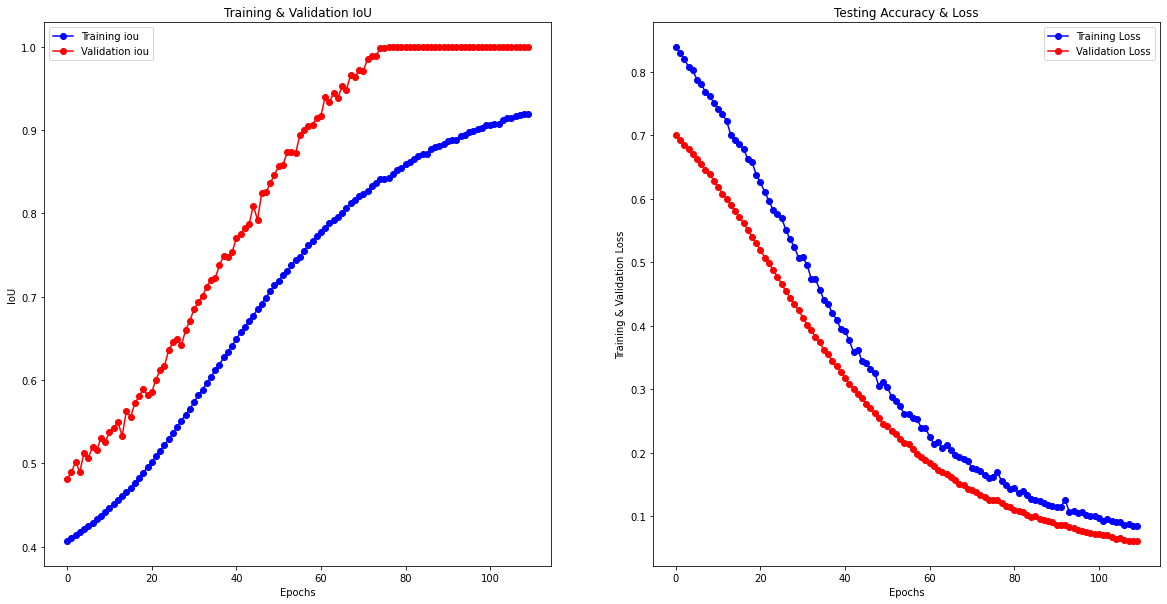

In [11]:
epochs = [i for i in range(110)]
fig , ax = plt.subplots(1, 2)
fig.set_size_inches(20,10)
train_loss = [loss.item() for loss in train_loss]
valid_loss = [loss.item() for loss in valid_loss]

ax[0].plot(epochs , train_iou , 'bo-' , label = 'Training iou')
ax[0].plot(epochs , valid_iou , 'ro-' , label = 'Validation iou')
ax[0].set_title('Training & Validation IoU')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("IoU")

ax[1].plot(epochs , valid_loss , 'b-o' , label = 'Training Loss')
ax[1].plot(epochs , train_loss, 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

## Visualize the models output on 4 of target images (5%)

Run the model on 4 samples from the target set. Visualize the outcome by plotting the groud-truth labels, model's predicition, and the difference between them.

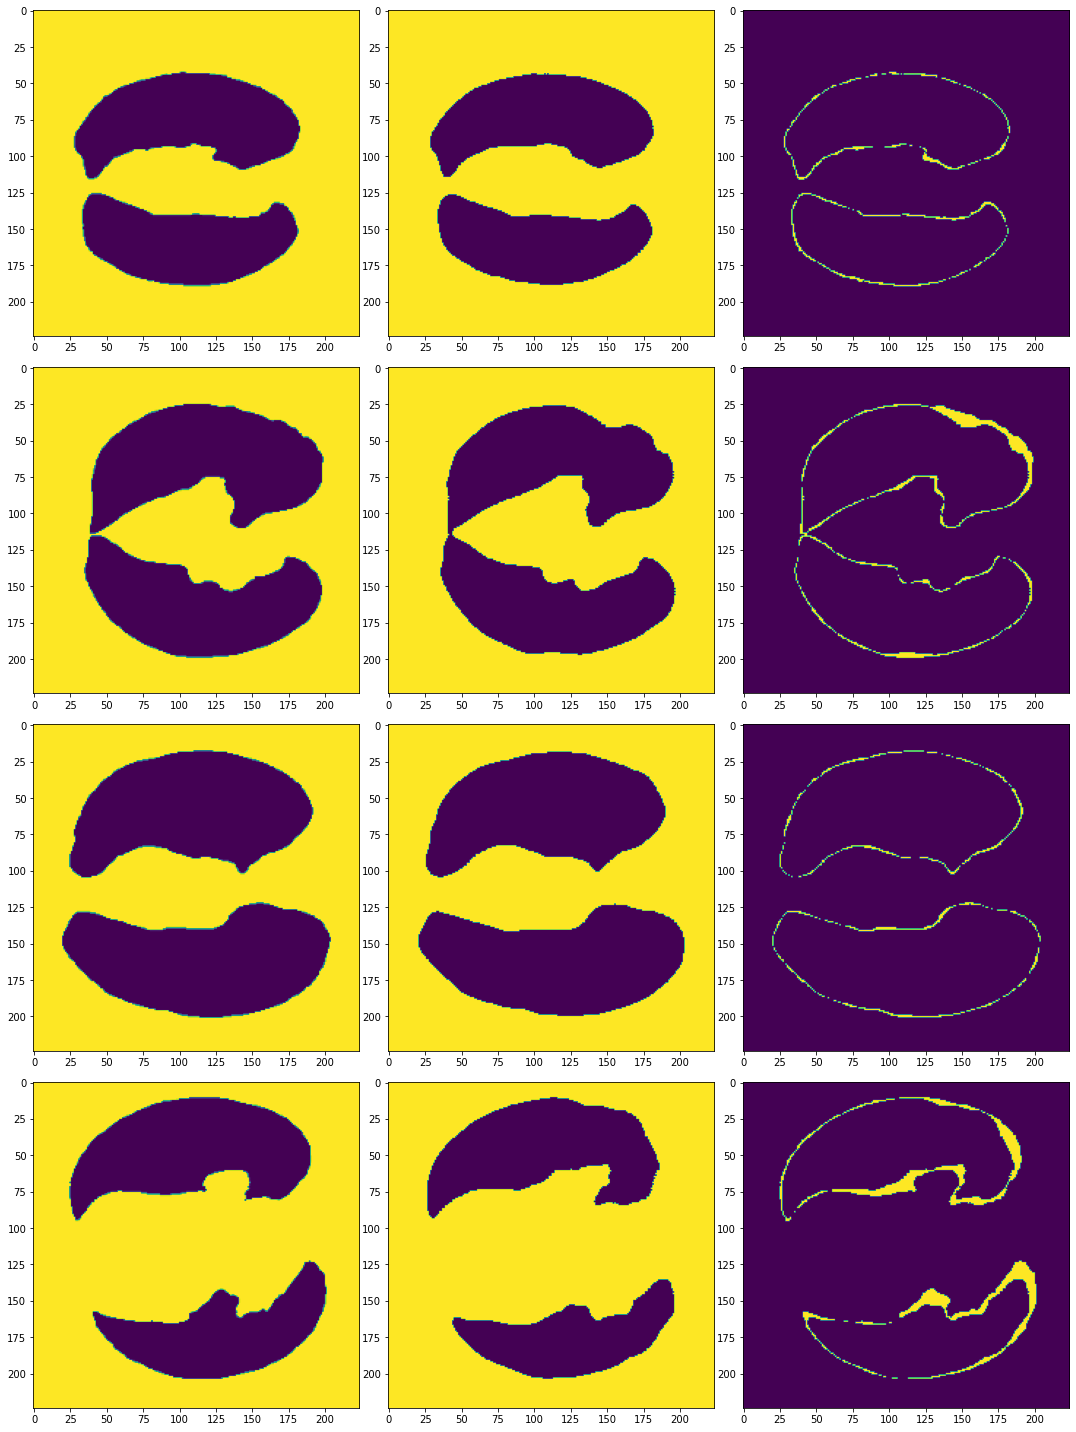

In [12]:
test (model, test_loader)

## Improve U-Net (Bonus) (10%)

In this bnous part, you can add your ideas for improving your model's performance. As an idea, you can search about exploiting IOU metric in the loss function. (you may use other ideas as well!) 

In [13]:
class IoULoss(nn.Module):
    def __init__(self):
        super().__init__()
    
    def forward(self, predict, target):
        predict_flat = torch.flatten(predict)
        target_flat = torch.flatten(target)
        iou = torch.sum(predict_flat * target_flat) /  torch.sum(predict_flat) + torch.sum(target_flat) - torch.sum(predict_flat * target_flat)
        return 1 - iou

In [15]:
def train(train_dl, valid_dl, iou_loss, bce_loss, optimizer, epochs):
    train_losses, valid_losses = [], []
    train_ious, valid_ious = [], []
    best_iou = 0.2

    for epoch in range(epochs):
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()
                train_loss, train_iou = 0.0, 0.0
                dataloader = train_loader
            else:
                model.eval()
                val_loss, val_iou = 0.0, 0.0
                dataloader = valid_loader
            step = 0
            for inputs, target in dataloader:
                inputs, target = inputs.cuda(), target.cuda()
                step += 1
                if phase == 'train':
                    optimizer.zero_grad()
                    outputs = model(inputs)
                    loss1 = iou_loss((outputs), target)
                    loss2 = bce_loss((outputs), target)
                    loss = 2 * loss1 + loss2
                    loss.backward()
                    optimizer.step()

                    iou = IoU(outputs, target)
                    train_iou  += iou * dataloader.batch_size
                    train_loss += loss * dataloader.batch_size 

                else:
                    with torch.no_grad():
                        outputs = model(inputs)
                        loss = criterion(outputs, target)
                        
                    iou = IoU(outputs, target)
                    val_iou  += iou * dataloader.batch_size
                    val_loss += loss * dataloader.batch_size 
            if phase == 'train':
              train_loss = train_loss / len(dataloader.dataset)
              train_iou = train_iou / len(dataloader.dataset)
            else:
              val_loss = val_loss / len(dataloader.dataset)
              val_iou = val_iou / len(dataloader.dataset)

            if phase == 'valid':
              if val_iou > best_iou  :
                best_iou = val_iou
                torch.save(model.state_dict(), "best_model_improved" + ".pth")

            if phase == 'train':
              print('Epoch {}/{} train Loss: {:.4f} iou: {}'.format(epoch + 1, epochs, train_loss, train_iou))
            else:
              print('Epoch {}/{} val Loss: {:.4f} iou: {}'.format(epoch + 1, epochs, val_loss, val_iou))

        train_losses.append(train_loss)
        valid_losses.append(val_loss)
        train_ious.append(train_iou)
        valid_ious.append(val_iou)

    return train_loss, valid_loss, train_iou, valid_iou

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
iou_loss = IoULoss()
bce_loss = nn.BCELoss()
train_loss, valid_loss, train_iou, valid_iou = train(train_loader, valid_loader, criterion, optimizer, epochs=70)

Epoch 1/70 val Loss: 0.6840 iou: 0.41858378052711487
Epoch 1/70 train Loss: 0.8200 iou: 0.5048531293869019
Epoch 2/70 val Loss: 0.6728 iou: 0.42405733466148376
Epoch 2/70 train Loss: 0.8056 iou: 0.5123769640922546
Epoch 3/70 val Loss: 0.6623 iou: 0.4291919767856598
Epoch 3/70 train Loss: 0.7887 iou: 0.5068170428276062
Epoch 4/70 val Loss: 0.6521 iou: 0.4341670572757721
Epoch 4/70 train Loss: 0.7770 iou: 0.5280412435531616
Epoch 5/70 val Loss: 0.6442 iou: 0.4381573796272278
Epoch 5/70 train Loss: 0.7665 iou: 0.5331507921218872
Epoch 6/70 val Loss: 0.6344 iou: 0.4427664875984192
Epoch 6/70 train Loss: 0.7519 iou: 0.5206455588340759
Epoch 7/70 val Loss: 0.6249 iou: 0.44732481241226196
Epoch 7/70 train Loss: 0.7451 iou: 0.5335246920585632
Epoch 8/70 val Loss: 0.6150 iou: 0.4521244168281555
Epoch 8/70 train Loss: 0.7333 iou: 0.5414401292800903
Epoch 9/70 val Loss: 0.6064 iou: 0.4565357565879822
Epoch 9/70 train Loss: 0.7202 iou: 0.5353403091430664
Epoch 10/70 val Loss: 0.5967 iou: 0.4614662